In [1]:
import numpy as np
import recycle as re
import matplotlib.pyplot as plt
from ripser import Rips
from persim import plot_diagrams
from scipy.linalg import svdvals

In [131]:
import matplotlib.colors as mcolors

# Your specific colors
color_list = ['#0283F8', '#FFA500','#00C49A', '#FF0059']
# Create a ListedColormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("CustomColormap", color_list)

colors = {
    "red":'#FF0059',
    "blue":'#0283F8',
    "green":'#00C49A',
    "orange":'#FFA500',
   "purple":'#5751d0'
}

# Doublesine wave

In [3]:
#function
size = 1000
bounds = 60*np.pi
rate = bounds/size
x = np.linspace(0,bounds,size)
fx = 2*np.sin(x)+1.8*np.sin(np.sqrt(3)*x)

mosaic = """
A
B
"""
freqs, coefs, peaks = re.timeseries.find_frequency_peaks(
    fx, x, min_height=0.1, distance=1
)

# delays
rate = bounds / size
delays = np.linspace(0, 45 * rate, 100)
average_orth = [re.timeseries.gamma_value(tau, freqs[peaks]) for tau in delays]
min_delay = delays[np.argmin(average_orth)]
delay = int(min_delay // rate)


vandermond = re.timeseries.omega_matrix(min_delay, freqs[peaks])
sigma = svdvals(vandermond)
f_approx = re.timeseries.reconstruct_signal(coefs, peaks)
diff = np.abs(fx - f_approx)
lower_bound = np.sqrt(3) * np.max(np.abs(coefs[peaks])) * np.min(sigma) - np.sqrt(
    np.sum(peaks) + 1
) * np.max(diff)

# embedding
embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=delay)
bad_embedding = re.timeseries.time_delay_embedding(fx, dimension=np.sum(peaks), delay=int((2*np.pi)//rate))

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from matplotlib.tri import Triangulation
import utils
from importlib import reload
utils = reload(utils)


def higher_embedding_plot(embedding, ax,cycles = None,cmap="viridis",edgecolor="gray",view=(20,20),grid=True):
    # Clear any existing content on the axis
    ax.clear()
    # Ensure it's a 3D axis
    if not hasattr(ax, 'get_zlim'):
        raise ValueError("Axis must be a 3D axis")
    # Perform PCA
    pca = PCA(n_components=3).fit_transform(embedding)
    # Scatter plot
    ax.plot(pca[:,0], pca[:,1], pca[:,2], alpha=1,linewidth=0.5,linestyle="--",color="gray")
    #ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.',s=1,alpha=0.9)
    ax.view_init(*view)
    
    # Remove tick labels
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_ticklabels([])

    # Create the triangular surface
    if cycles:
        X = pca[::4][:, 0]
        Y = pca[::4][:, 1]
        Z = pca[::4][:, 2]
        ax.plot_trisurf(X, Y, Z, triangles=list(cycles), cmap=cmap, edgecolor=edgecolor)

    ax.grid(grid)
    ax.set_xlim(-3, 3);ax.set_ylim(-3, 3);ax.set_zlim(-3, 3)

In [5]:
#helper function to create the length weight matrix
def edge_length_function(points):
    def edge_length(simp1, simp2):
        if simp1 == simp2:
            return np.linalg.norm(points[simp1[0]] - points[simp1[1]])
        else:
            return 0

    return edge_length


def barcode_biggest_cycle(diags,dimension):
    persistence = diags[dimension][:, 1] - diags[dimension][:, 0]
    cycle = np.argmax(persistence)
    birth, death = diags[dimension][cycle]
    return birth,death

In [133]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as mcolors
import numpy as np
from sklearn.decomposition import PCA

# Custom colormap similar to SHAP's
shap_colors = ['#0283F8', '#0078F3', '#3369E8', '#605BDA', "#7D49CB",
          "#9331B7", "#A918A8", "#C4009A", "#DA008B", "#EA007B",
          "#F7006A", "#FF0059"]

n_bins = len(colors)
shap_cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", shap_colors, N=n_bins)



# Define a scalar field for coloring (e.g., the Z values)

def plot_selection(x,fx,cycle,color,ax):
    vertex_set = {item for tup in cycle for item in tup}
    for vertex in vertex_set:
        ax.axvline(x[vertex], color=color, alpha=0.75,linewidth=2)
    
    ax.plot(x, fx,alpha=0.8,color="gray")
    ax.spines[["top", "right"]].set_visible(False)
    ax.tick_params(axis='both', which='major', labelsize=5)
    ax.scatter(x[list(vertex_set)],fx[list(vertex_set)],color=color,s=20,edgecolors="white",linewidths=1,zorder=2)
    ax.set_xticklabels([])

def h2_plot(embedding,cycle,ax,view=(20,20)):
    # PCA for reducing to 3D
    pca = PCA(n_components=3).fit_transform(embedding)
    X = pca[::4][:, 0]
    Y = pca[::4][:, 1]
    Z = pca[::4][:, 2]
    scalar_field = Z  # Replace with any scalar values if needed
    # Create the triangular surface with the colormap
    ax.plot_trisurf(X, Y, Z, triangles=list(cycle), cmap=shap_cmap, shade=True, lightsource = (-5,5,5),vmin=np.min(scalar_field), vmax=np.max(scalar_field),edgecolor="black",linewidth=0.2)
    #ax.scatter(pca[:,0], pca[:,1], pca[:,2],marker='.',s=1,alpha=0.9)
    ax.view_init(*view)
    # Remove tick labels
    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
        axis.set_ticklabels([])
    ax.grid(True)
    ax.set_xlim(-3, 3);ax.set_ylim(-3, 3);ax.set_zlim(-3, 3)


def time_adjacency_matrix(norm=np.mean):
    def inner_time_adjacency_matrix(simplex_j, simplex_i):
        if are_simplices_adjacent(simplex_j, simplex_i):
            return time_weight(simplex_i, simplex_j,norm=norm)
        else:
            return 0

    return inner_time_adjacency_matrix

def time_label(simplex_i,norm):
    return norm(simplex_i)

def time_weight(simp1, simp2,norm) -> float:
    return np.abs(time_label(simp1,norm=norm) - time_label(simp2,norm=norm))

def are_simplices_adjacent(simplex1, simplex2):
    # Count common elements between the two tuples
    common_elements = set(simplex1).intersection(set(simplex2))
    # Two simplices are adjacent if they share exactly n-1 elements
    if len(common_elements) == len(simplex1) - 1:
        return 1
    return 0

def vertex_time_difference(
    inv_row_map,
) -> np.ndarray:
    n = len(inv_row_map)
    weight_matrix = np.zeros((n, n))

    for i in range(n):
      simplex_i = inv_row_map[i]
      weight_matrix[i,i] = np.abs(simplex_i[0]-simplex_i[1])
    return weight_matrix

In [6]:
#parameters
points = embedding[::4]


# get death point
rips = Rips(maxdim=2)
diags = rips.fit_transform(points)
_,death = barcode_biggest_cycle(diags,dimension = 2)
max_edge_length = death*1.01


Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [8]:
import itertools
#compute Rips complex
dimension = 3
gudhi_complex = re.core.create_simplicial_complex(points, max_edge_length, dimension)

#manually reduce the boundary matrix
#get 2 most persistent representatives
boundary_map = {
    tuple(sorted(simplex)): set(
        itertools.combinations(tuple(sorted(simplex)), len(simplex) - 1)
    )
    - {tuple()}
    for simplex, _radius in gudhi_complex.get_filtration()
}

R = {k: v for k, v in boundary_map.items()}
# V = { k : {k} for k in boundary_map}
lowinv = {}  # lowinv[i]=index of column with the lowest 1 at i
order_function = lambda s: (gudhi_complex.filtration(s), s)
for s in sorted(R, key=order_function):
    t = lowinv.get(max(R[s], key=order_function), -1) if len(R[s]) != 0 else -1
    while t != -1:
        R[s] = R[t] ^ R[s]  # symmetric difference of t-th and s-th columns
        # V[s] = V[t]^V[s]
        t = lowinv.get(max(R[s], key=order_function), -1) if len(R[s]) != 0 else -1
    if len(R[s]) != 0:
        lowinv[max(R[s], key=order_function)] = s


In [40]:
loops = [bar for bar in lowinv.items() if len(bar[0]) == 3]
cycle = max(loops, key=lambda bar: gudhi_complex.filtration(bar[1])-gudhi_complex.filtration(bar[0]))

reduced_boundary_base = {
    simplex
    for simplex, boundary in R.items()
    if len(simplex) == dimension + 1 and len(boundary) > 0
}

representative = R[cycle[1]]
birth = gudhi_complex.filtration(cycle[0])
death = gudhi_complex.filtration(cycle[1])

In [50]:
min_persistence = lower_bound #this doesnt work because of subsampling
min_persistence = (death-birth)*0.5 #halve it
# ISOLATED
np1_simplices = sorted(
    {
        simplex
        for simplex in reduced_boundary_base
        if gudhi_complex.filtration(simplex) <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
n_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)
nm1_simplices = sorted(
    {
        tuple(sorted(simplex))
        for simplex, radius in gudhi_complex.get_filtration()
        if len(simplex) == dimension - 1 and radius <= (death - min_persistence)*1.01 #slack for rounding errors
    },
    key=order_function,
)

In [51]:
W = vertex_time_difference(n_simplices)
x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)
#optimize each
x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
    boundary_matrix, x_orig, W, use_gurobi=True,verbose=False
)
min_cycle = set(
    [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
)  # be carefull here with values close to zero, add a tolerance parameter

In [62]:
W = re.core.create_weight_matrix(n_simplices, time_adjacency_matrix(np.mean))
x_orig = re.core.lift_representative(representative, nm1_simplices, n_simplices)
boundary_matrix = re.core.build_boundary_matrix(n_simplices, np1_simplices)
#optimize each
x_min, status, objective_value = re.core.find_minimal_homologous_cycle(
    boundary_matrix, x_orig, W, use_gurobi=True,verbose=False
)
mean_cycle = set(
    [n_simplices[index] for index in np.argwhere(~np.isclose(x_min, 0)).flatten()]
)  # be carefull here with values close to zero, add a tolerance parameter

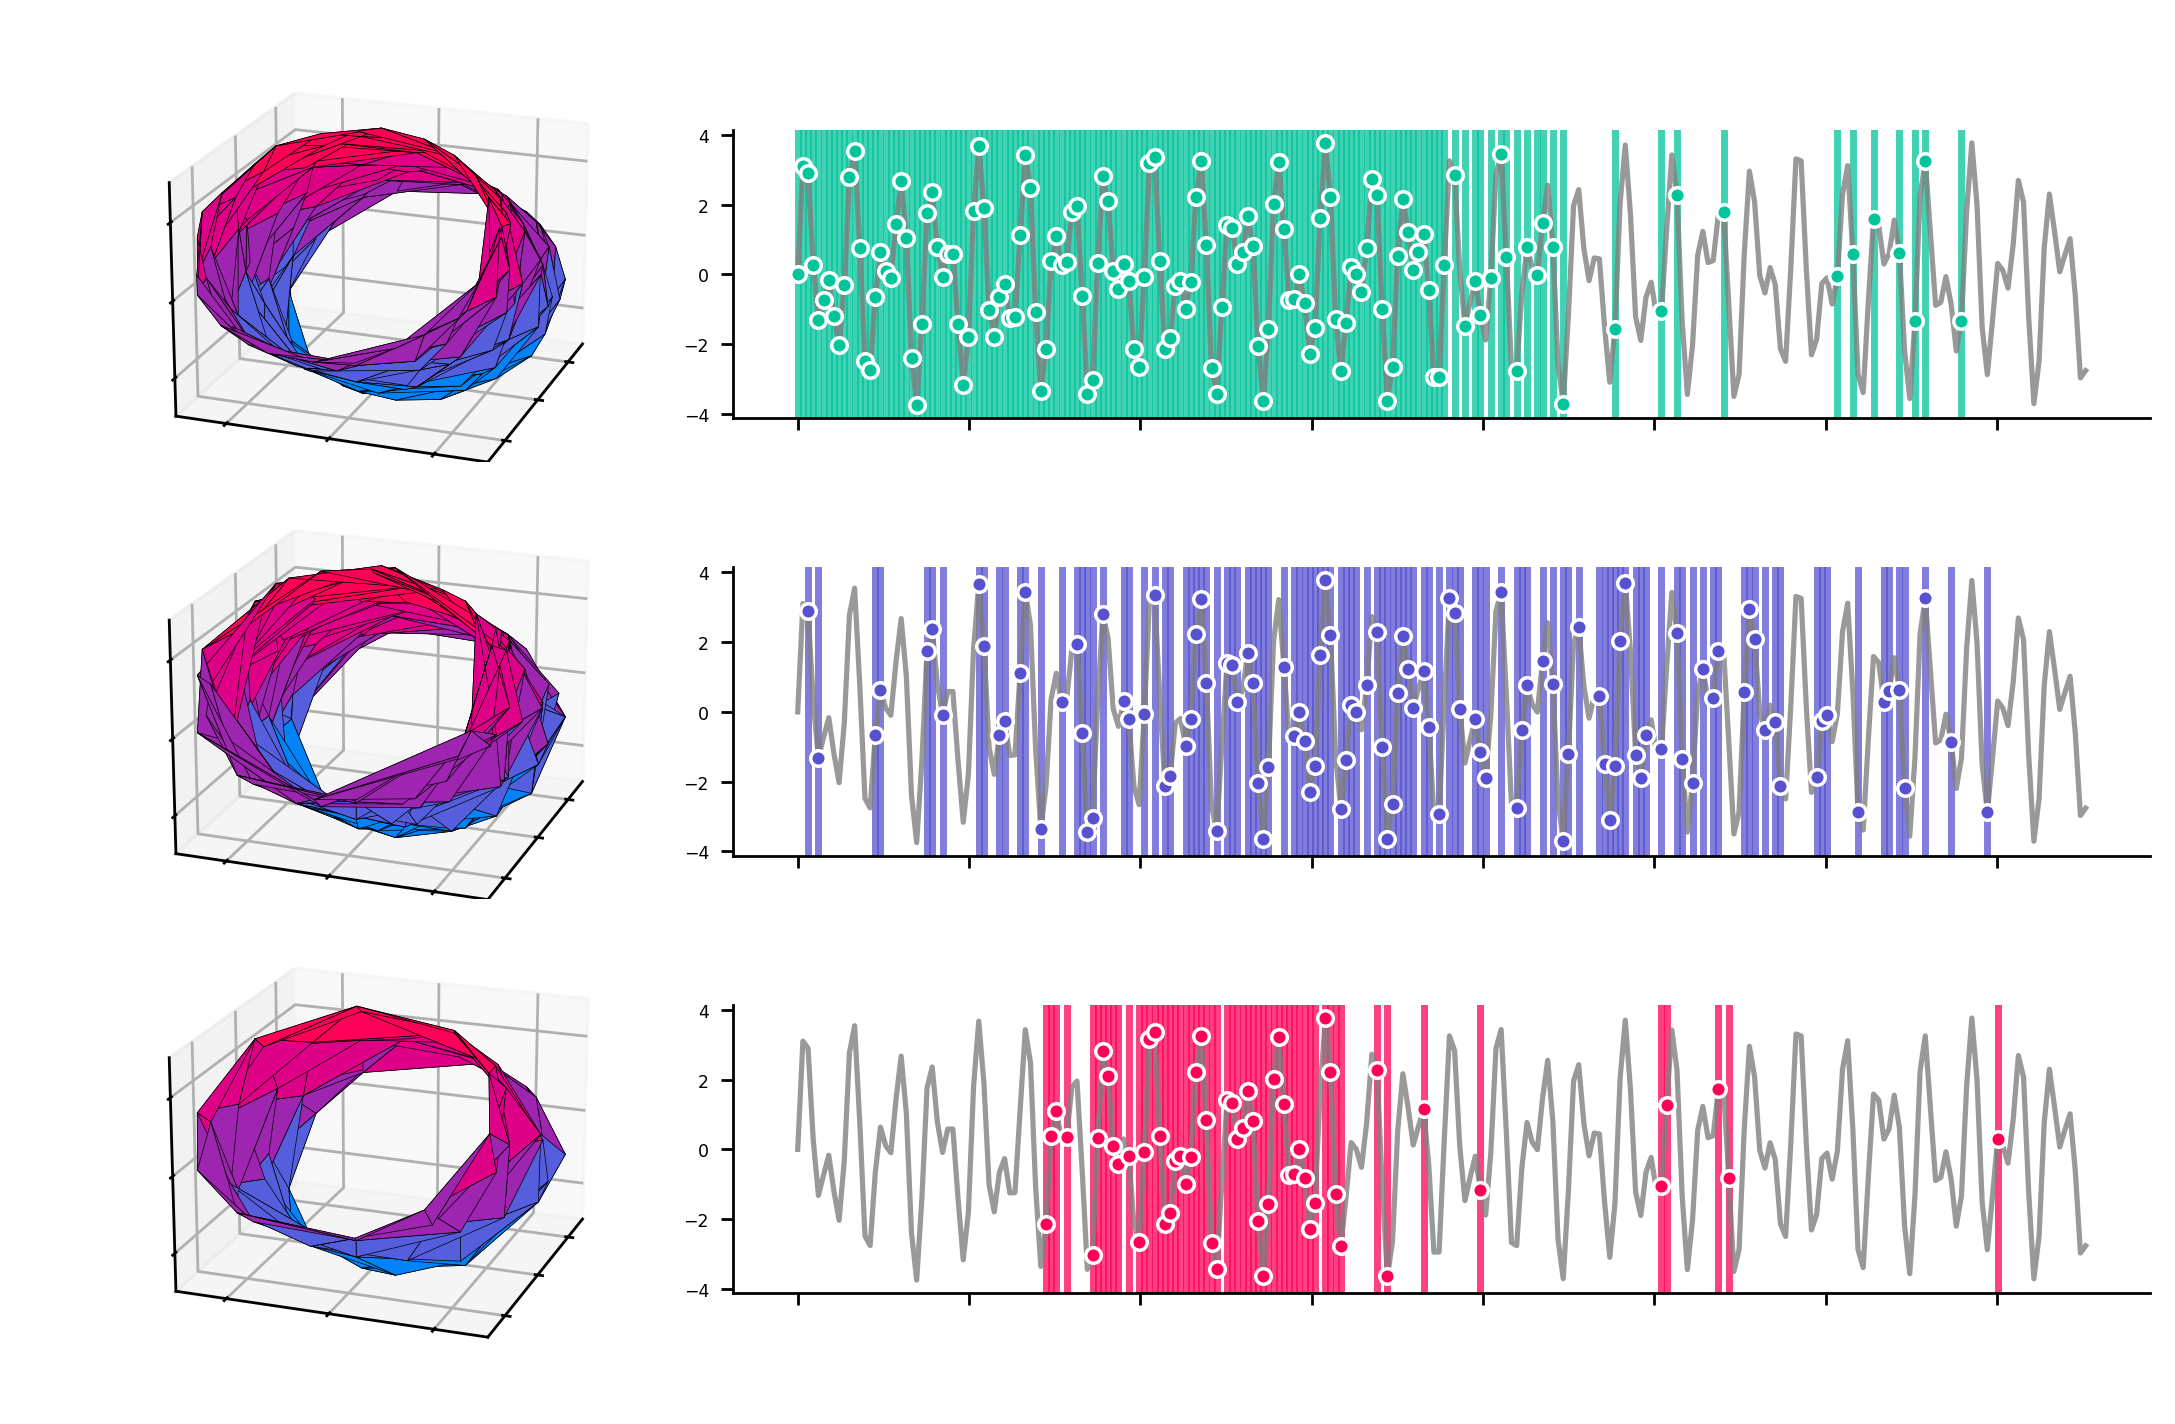

In [169]:
fig = plt.figure(figsize=(8.5, 5.5), dpi=250)
gs = fig.add_gridspec(
    11, 2, 
    height_ratios=[0.5,1,0.5,0.05,0.5,1,0.5,0.05,0.5,1,0.5],  # Equal height for both rows
    width_ratios=[0.5, 1],  # Wider right column, smaller left column
    wspace=0,  # Slight space between columns (you can adjust this)
    hspace=-0.24   # Space between rows (adjust to your preference)
)


ax = fig.add_subplot(gs[0, 0])
ax.axis("off")
ax = fig.add_subplot(gs[2:5, 0])
ax.axis("off")
ax = fig.add_subplot(gs[6:9, 0])
ax.axis("off")
ax = fig.add_subplot(gs[10, 0])
ax.axis("off")

ax = fig.add_subplot(gs[:3, 0], projection='3d')
h2_plot(embedding,representative,ax=ax)
ax = fig.add_subplot(gs[4:7, 0], projection='3d')
h2_plot(embedding,mean_cycle,ax=ax)
ax = fig.add_subplot(gs[8:, 0], projection='3d')
h2_plot(embedding,min_cycle,ax=ax)

ax = fig.add_subplot(gs[1, 1])
plot_selection(x[::4],fx[::4],representative,color=colors["green"],ax=ax)

ax = fig.add_subplot(gs[5, 1])
plot_selection(x[::4],fx[::4],mean_cycle, color=colors["purple"], ax=ax)

ax = fig.add_subplot(gs[9, 1])
plot_selection(x[::4],fx[::4],min_cycle, color=colors["red"],ax=ax)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
#plt.savefig("Figures/example_doublesine_representative_h2.png",bbox_inches='tight')
plt.show()
